In [1]:
import numpy as np
import scipy.stats as sst
import pandas as pd
import copy
import re
from collections import defaultdict
from configparser import ConfigParser
import pathlib as pl
from functools import reduce

import joblib as jl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import r2_score
from IPython.display import Image

from src.root_path import config_path
from src.utils.subsets import cellid_A1_fit_set, cellid_PEG_fit_set, batch_map
from src.data.rasters import load_site_formated_prediction
from src.models.modelnames import modelnames
from src.models.param_tools import get_pred_err
from src.visualization.fancy_plots import squarefy
from src.visualization.palette import *

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2022-04-25 172731.log


# Models are not linearly summed
clearly the predictions of the full pop_mod_relu is smaller than the sum of its parts: STRF_long_relu and  pop_lone_relu

at lest not for this example site/cell

loading predicted response for TNC014a with modelspec
ozgf.fs100.ch18-ld-norm.l1-epcpn.seq-avgreps_wc.18x1.g-fir.1x30-lvl.1-relu.1_jk.nf10-tfinit.n.lr1e3.et3.cont-newtf.n.lr1e4.cont-svpred

loading predicted response for TNC014a with modelspec
ozgf.fs100.ch18-ld.popstate-norm.l1-dline.15.15.1-epcpn.seq-avgreps_wc.18x1.g-fir.1x15-lvl.1-relu.1-stategain.S.d_jk.nf10-tfinit.n.lr1e3.et3.cont-newtf.n.lr1e4.cont-svpred

loading predicted response for TNC014a with modelspec
ozgf.fs100.ch18-ld.popstate-norm.l1-dline.15.15.1.i.state.o.stim-epcpn.seq-avgreps_wc.Nx1-fir.1x1-lvl.1-relu.1_jk.nf10-tfinit.n.lr1e3.et3.cont-newtf.n.lr1e4.cont-svpred



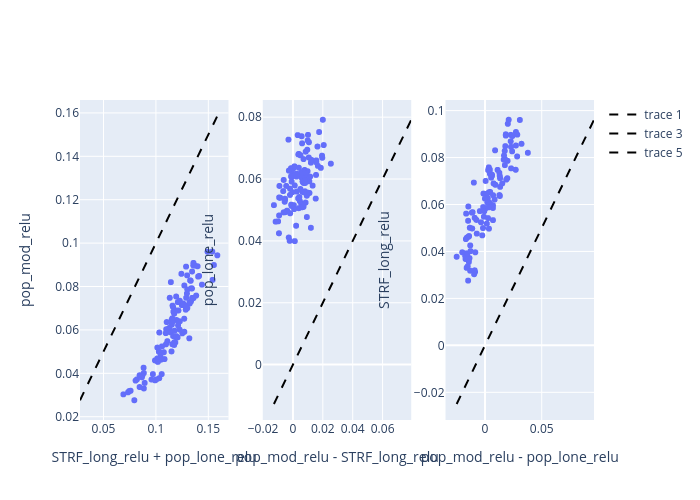

In [2]:
# for a given cell load the model strfs
site = 'TNC014a'
batch = 326
cellid = 'TNC014a-22-2'


selected_models = ['STRF_long_relu', 'pop_mod_relu', 'pop_lone_relu']
rasters = dict()
for nickname, modelname in modelnames.items():
    if nickname not in selected_models:
        continue
    rasters[nickname], goodcells = load_site_formated_prediction(site, modelname=modelname, batch=batch, cellid=cellid)


variances = {key:np.mean(val, axis=-1) for key, val in rasters.items()}


sum_var = np.mean(rasters['STRF_long_relu'] + rasters['pop_lone_relu'], axis=-1)
x = sum_var.squeeze().flatten()
y = variances['pop_mod_relu'].squeeze().flatten()
plot_range = [np.stack([x,y]).min(), np.stack([x,y]).max()]
fig_sum = px.scatter(x=x,y=y)
fig_sum.add_trace(go.Scatter(x=plot_range, y=plot_range, mode='lines', line_color='black', line_dash='dash'))


diff_var = np.mean(rasters['pop_mod_relu'] - rasters['STRF_long_relu'], axis=-1)
x = diff_var.squeeze().flatten()
y = variances['pop_lone_relu'].squeeze().flatten()
plot_range = [np.stack([x,y]).min(), np.stack([x,y]).max()]
fig_diff1 = px.scatter(x=x,y=y)
fig_diff1.add_trace(go.Scatter(x=plot_range, y=plot_range, mode='lines', line_color='black', line_dash='dash'))


diff_var = np.mean(rasters['pop_mod_relu'] - rasters['pop_lone_relu'], axis=-1)
x = diff_var.squeeze().flatten()
y = variances['pop_mod_relu'].squeeze().flatten()
plot_range = [np.stack([x,y]).min(), np.stack([x,y]).max()]
fig_diff2 = px.scatter(x=x,y=y)
fig_diff2.add_trace(go.Scatter(x=plot_range, y=plot_range, mode='lines', line_color='black', line_dash='dash'))


fig = make_subplots(1,3)
fig.add_traces(fig_sum['data'], rows=[1] * len(fig_sum['data']), cols=[1] * len(fig_sum['data']))
fig.update_xaxes(title_text='STRF_long_relu + pop_lone_relu', col=1, row=1)
fig.update_yaxes(scaleratio=1, title_text='pop_mod_relu', col=1, row=1)

fig.add_traces(fig_diff1['data'], rows=[1] * len(fig_diff1['data']), cols=[2] * len(fig_diff1['data']))
fig.update_xaxes(title_text='pop_mod_relu - STRF_long_relu', col=2, row=1)
fig.update_yaxes(scaleratio=1, title_text='pop_lone_relu', col=2, row=1)


fig.add_traces(fig_diff2['data'], rows=[1] * len(fig_diff2['data']), cols=[3] * len(fig_diff2['data']))
fig.update_xaxes(title_text='pop_mod_relu - pop_lone_relu', col=3, row=1)
fig.update_yaxes(scaleratio=1, title_text='STRF_long_relu', col=3, row=1)

# fig.show()
img_bytes = fig.to_image(format="png")
Image(img_bytes)

# Agreagate errors and difference for singificant or non significant instances


## errors but with non significant instances

In [13]:
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_BS'
DF_mass = jl.load(summary_DF_file)
print(DF_mass.shape)
print(DF_mass.info())
filtered = DF_mass.query(
    f"mult_comp_corr == 'bf_cp' and source == 'real' and "
    f"cluster_threshold == 0.05 and value > 0 and id in {list(cellid_A1_fit_set.union(cellid_PEG_fit_set))}"
)
actual_mean_metrics = filtered.groupby(['metric']).agg(value=('value','mean'))
actual_mean_metrics

(10538880, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10538880 entries, 0 to 10538879
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   id                 object 
 1   context_pair       object 
 2   probe              object 
 3   value              object 
 4   metric             object 
 5   mult_comp_corr     object 
 6   analysis           object 
 7   site               object 
 8   region             object 
 9   source             object 
 10  cluster_threshold  float64
 11  stim_count         int64  
dtypes: float64(1), int64(1), object(10)
memory usage: 964.9+ MB
None


,value
metric,
integral,588.874547
integral_trunc1.5,487.123569
last_bin,174.574380
mass_center,118.435699
mass_center_trunc1.5,262.883892


In [4]:
def plot_pooled(file, source, line_dashing='full', sufix='', colors=None):
    pooled_differences, pooled_errors, labels, instance_counter = jl.load(file)

    neu, tme = pooled_differences['response'].shape
    fs = int(re.findall('\.fs\d*\.', modelnames['STRF_long_relu'])[0][3:-1])
    duration = tme / fs
    time = np.linspace(0, duration, tme, endpoint=False)

    if colors is None:
        colors = [Grey, Yellow, Red, Teal, Brown]

    if source == 'difference':
        selected_source = pooled_differences
    elif source == 'error':
        selected_source = pooled_errors

    fig = go.Figure()
    for mm, (nickname, diff_arr) in enumerate(selected_source.items()):
        color = colors[mm % len(colors)]

        toplot = diff_arr.mean(axis=0)
        name = f'{nickname} {sufix} n={instance_counter}'
        x, y = squarefy(time, toplot)
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                 line=dict(color=color,
                                           width=3,
                                           dash=line_dashing),
                                 name=name, showlegend=True))

    return fig


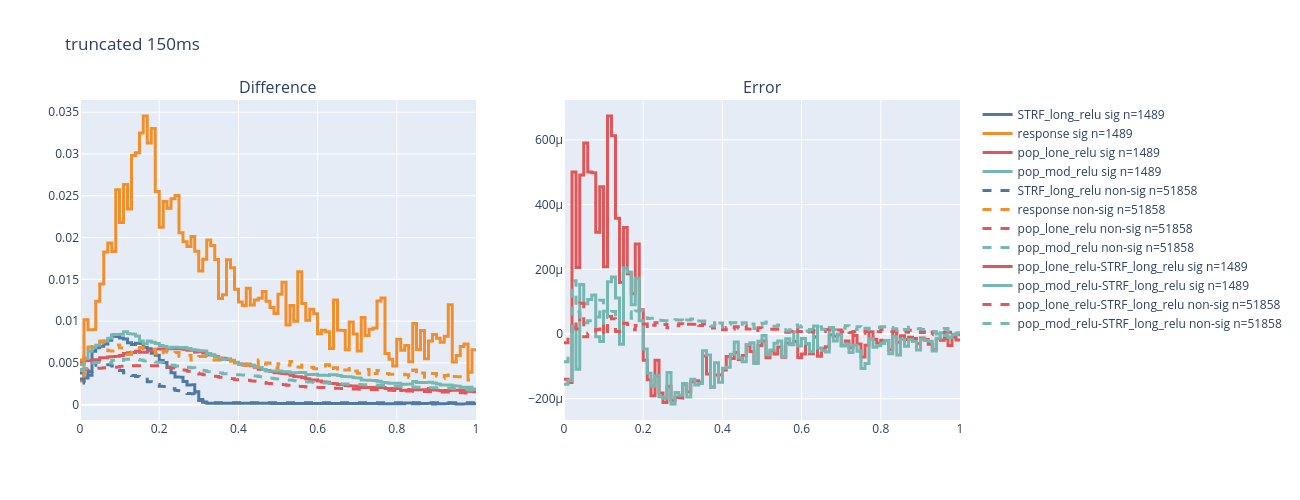

In [5]:
# left the overlayed differences
colors = [Blue, Orange, Red, Teal]
cache_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_differences_trunc150'
signif_diff_fig = plot_pooled(cache_file, source='difference', line_dashing='solid', sufix='sig', colors=colors)
cache_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_nonsig_differences'
nonsignif_diff_dif= plot_pooled(cache_file, source='difference', line_dashing='dash', sufix='non-sig', colors=colors)


colors = [Red, Teal]
cache_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_differences_trunc150'
signif_err_fig = plot_pooled(cache_file, source='error', line_dashing='solid', sufix='sig', colors=colors)
cache_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_nonsig_differences'
nonsignif_err_diff = plot_pooled(cache_file, source='error', line_dashing='dash', sufix='non-sig', colors=colors)


fig = make_subplots(1,2, shared_xaxes=False, shared_yaxes=False, subplot_titles=['Difference', 'Error'])

fig.add_traces(signif_diff_fig.data, rows=[1]*len(signif_diff_fig.data), cols=[1]*len(signif_diff_fig.data))
fig.add_traces(nonsignif_diff_dif.data, rows=[1]*len(nonsignif_diff_dif.data), cols=[1]*len(nonsignif_diff_dif.data))

fig.add_traces(signif_err_fig.data, rows=[1]*len(signif_err_fig.data), cols=[2]*len(signif_err_fig.data))
fig.add_traces(nonsignif_err_diff.data, rows=[1]*len(nonsignif_err_diff.data), cols=[2]*len(nonsignif_err_diff.data))

fig.update_layout(title_text='truncated 150ms')
# fig.show()
img_bytes = fig.to_image(format="png", width=1300)
Image(img_bytes)

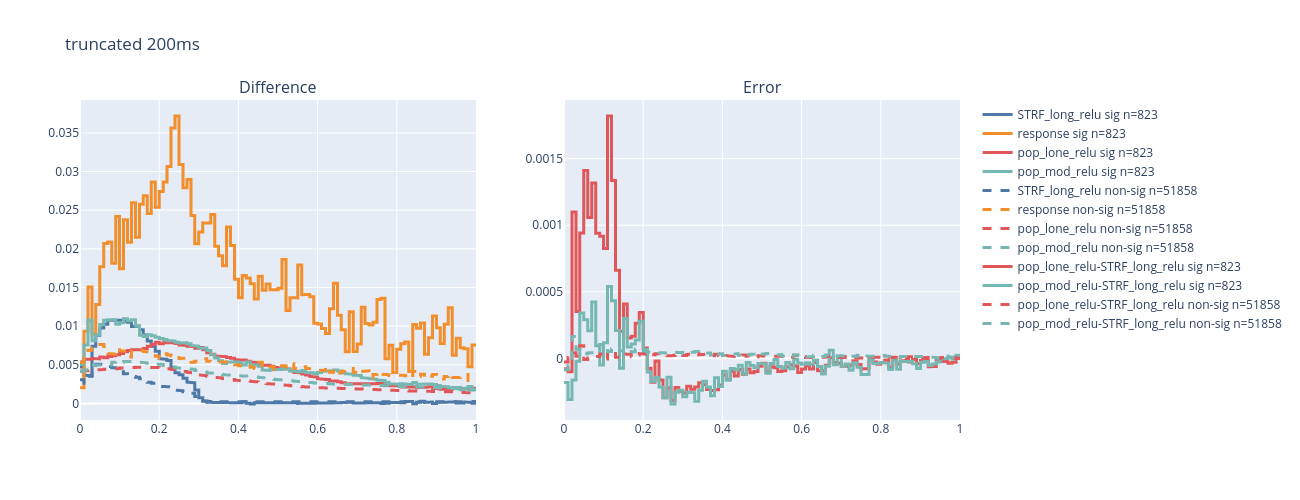

In [44]:
# left the overlayed differences
colors = [Blue, Orange, Red, Teal]
cache_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_differences_trunc200'
signif_diff_fig = plot_pooled(cache_file, source='difference', line_dashing='solid', sufix='sig', colors=colors)
cache_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_nonsig_differences'
nonsignif_diff_dif= plot_pooled(cache_file, source='difference', line_dashing='dash', sufix='non-sig', colors=colors)


colors = [Red, Teal]
cache_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_differences_trunc200'
signif_err_fig = plot_pooled(cache_file, source='error', line_dashing='solid', sufix='sig', colors=colors)
cache_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_nonsig_differences'
nonsignif_err_diff = plot_pooled(cache_file, source='error', line_dashing='dash', sufix='non-sig', colors=colors)


fig = make_subplots(1,2, shared_xaxes=False, shared_yaxes=False, subplot_titles=['Difference', 'Error'])

fig.add_traces(signif_diff_fig.data, rows=[1]*len(signif_diff_fig.data), cols=[1]*len(signif_diff_fig.data))
fig.add_traces(nonsignif_diff_dif.data, rows=[1]*len(nonsignif_diff_dif.data), cols=[1]*len(nonsignif_diff_dif.data))

fig.add_traces(signif_err_fig.data, rows=[1]*len(signif_err_fig.data), cols=[2]*len(signif_err_fig.data))
fig.add_traces(nonsignif_err_diff.data, rows=[1]*len(nonsignif_err_diff.data), cols=[2]*len(nonsignif_err_diff.data))

fig.update_layout(title_text='truncated 200ms')

# fig.show()
img_bytes = fig.to_image(format="png", width=1300)
Image(img_bytes)

## differences, 100 ms truncated significance filter
calculated for signficant instancese, for the real data, and model predictions; and flipped so the sum difference is possitive

In [ ]:
def plot_pooled2(files, source, line_dashing, sufix, colors=None, norm_real=False, showlegend=True):
    if colors is None:
        colors = [Grey, Yellow, Red, Teal, Brown]

    # pools all the lines together for easier  normalization:
    lines_to_plot = list()
    colors_to_plot = list()
    dashings_to_plot = list()
    names_to_plot = list()
    is_real = list()
    for ff, file in enumerate(files):
        pooled_differences, pooled_errors, labels, instance_counter = jl.load(file)
        if source == 'difference':
            selected_source = pooled_differences
        elif source == 'error':
            selected_source = pooled_errors

        for mm, (nickname, diff_arr) in enumerate(selected_source.items()):
            colors_to_plot.append(colors[mm % len(colors)])
            lines_to_plot.append(diff_arr.mean(axis=0))
            dashings_to_plot.append(line_dashing[ff])
            names_to_plot.append(f'{nickname} {sufix[ff]} n={instance_counter}')
            if nickname == 'response':
                is_real.append(True)
            else:
                is_real.append(False)

    is_real = np.asarray(is_real)
    lines_to_plot = np.stack(lines_to_plot, axis=0)

    if norm_real:
        pred_max = np.max(lines_to_plot[~is_real,:])
        resp_max = np.max(lines_to_plot[is_real,:])
        lines_to_plot[is_real,:] = lines_to_plot[is_real,:] * pred_max / resp_max

    tme = lines_to_plot.shape[1]
    time = np.linspace(0, tme / 100, tme, endpoint=False)

    fig = go.Figure()
    for toplot, color, dashing, name in zip(lines_to_plot, colors_to_plot, dashings_to_plot, names_to_plot):
        x, y = squarefy(time, toplot)
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines',
                                 line=dict(color=color,
                                           width=3,
                                           dash=dashing),
                                 name=name, showlegend=showlegend))

    return fig

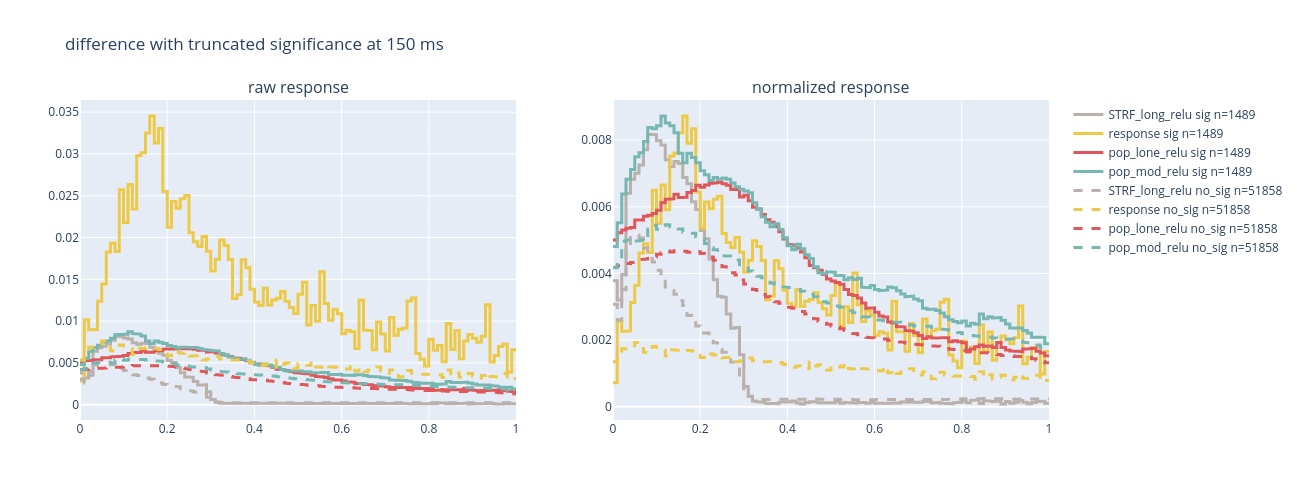

In [45]:

sig_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_differences_trunc150'
nosig_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_nonsig_differences'

fig_raw = plot_pooled2([sig_file, nosig_file], 'difference', ['solid', 'dash'], ['sig', 'no_sig'],
                 colors=None, norm_real=False, showlegend=False)

fig_norm = plot_pooled2([sig_file, nosig_file], 'difference', ['solid', 'dash'], ['sig', 'no_sig'],
                 colors=None, norm_real=True, showlegend=True)

fig = make_subplots(1,2, subplot_titles=['raw response', 'normalized response'])

fig.add_traces(fig_raw.data, rows=[1]*len(fig_raw.data), cols=[1]*len(fig_raw.data))
fig.add_traces(fig_norm.data, rows=[1]*len(fig_norm.data), cols=[2]*len(fig_norm.data))

fig.update_layout(title_text='difference with truncated significance at 150 ms')

# fig.show()
img_bytes = fig.to_image(format="png", width=1300)
Image(img_bytes)

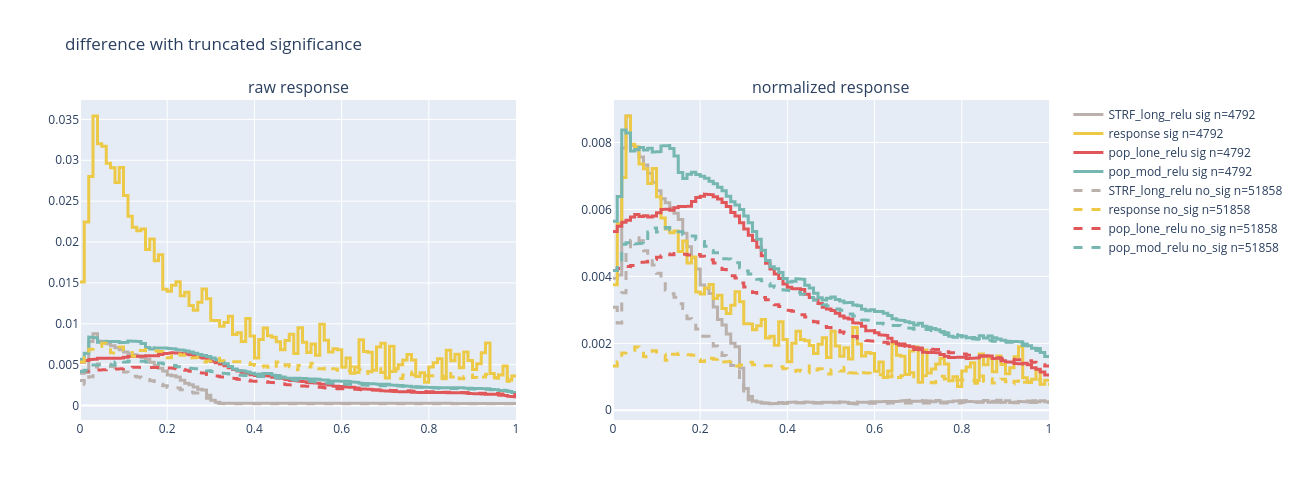

In [46]:
sig_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_differences'
nosig_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_nonsig_differences'

fig_raw = plot_pooled2([sig_file, nosig_file], 'difference', ['solid', 'dash'], ['sig', 'no_sig'],
                 colors=None, norm_real=False, showlegend=False)

fig_norm = plot_pooled2([sig_file, nosig_file], 'difference', ['solid', 'dash'], ['sig', 'no_sig'],
                 colors=None, norm_real=True, showlegend=True)

fig = make_subplots(1,2, subplot_titles=['raw response', 'normalized response'])

fig.add_traces(fig_raw.data, rows=[1]*len(fig_raw.data), cols=[1]*len(fig_raw.data))
fig.add_traces(fig_norm.data, rows=[1]*len(fig_norm.data), cols=[2]*len(fig_norm.data))

fig.update_layout(title_text='difference with truncated significance')

# fig.show()
img_bytes = fig.to_image(format="png", width=1300)
Image(img_bytes)

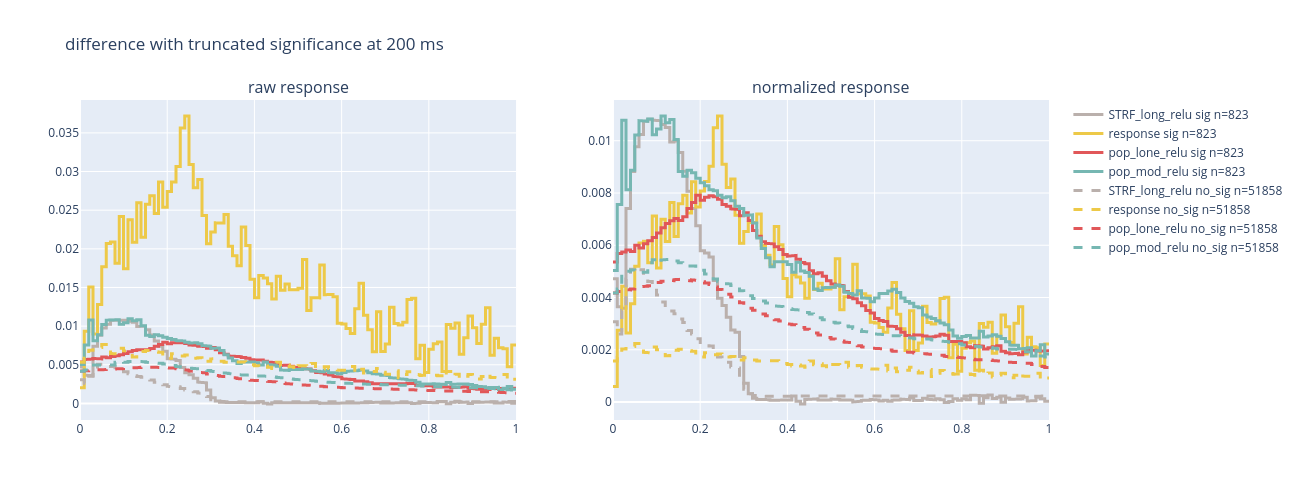

In [47]:

sig_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_differences_trunc200'
nosig_file = pl.Path(config['paths']['analysis_cache']) / '220408_pooled_nonsig_differences'

fig_raw = plot_pooled2([sig_file, nosig_file], 'difference', ['solid', 'dash'], ['sig', 'no_sig'],
                 colors=None, norm_real=False, showlegend=False)

fig_norm = plot_pooled2([sig_file, nosig_file], 'difference', ['solid', 'dash'], ['sig', 'no_sig'],
                 colors=None, norm_real=True, showlegend=True)

fig = make_subplots(1,2, subplot_titles=['raw response', 'normalized response'])

fig.add_traces(fig_raw.data, rows=[1]*len(fig_raw.data), cols=[1]*len(fig_raw.data))
fig.add_traces(fig_norm.data, rows=[1]*len(fig_norm.data), cols=[2]*len(fig_norm.data))

fig.update_layout(title_text='difference with truncated significance at 200 ms')

# fig.show()
img_bytes = fig.to_image(format="png", width=1300)
Image(img_bytes)

# compare difference lines with correlation

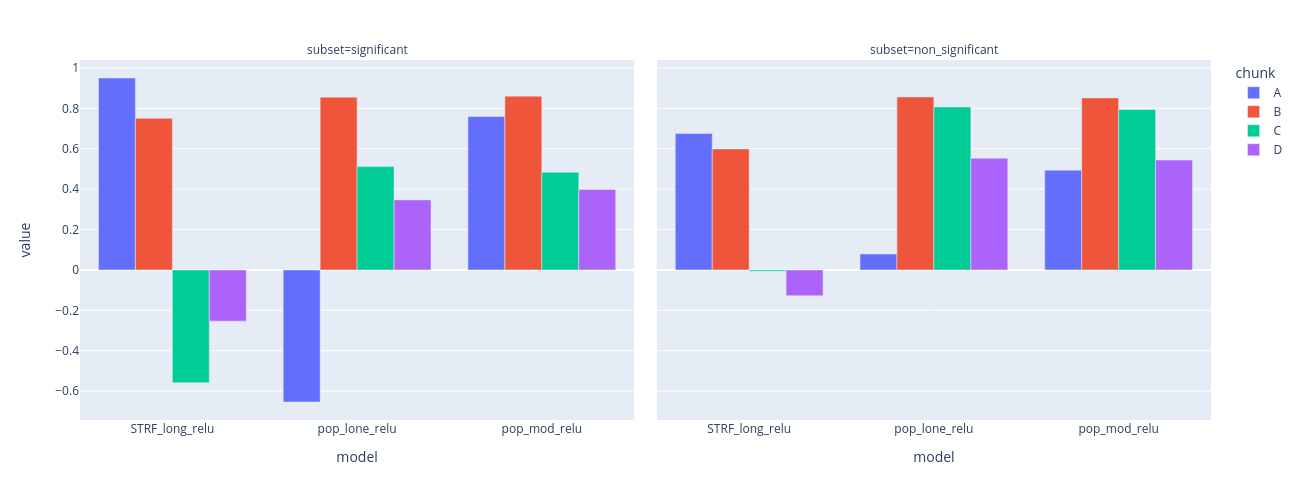

In [4]:
files = [pl.Path(config['paths']['analysis_cache']) / '220408_pooled_differences',
         pl.Path(config['paths']['analysis_cache']) / '220408_pooled_nonsig_differences']

signif_subsets = ['significant', 'non_significant']

chunks = {'A': np.s_[:25], 'B': np.s_[25:50], 'C': np.s_[50:75], 'D': np.s_[75:]}

df = list()
for ff, (file, signif_subset) in enumerate(zip(files, signif_subsets)):
    pooled_differences, _, _, instance_counter = jl.load(file)
    # get refference value, i.e. real value
    reff_mean = pooled_differences.pop('response').mean(axis=0)

    for mm, (nickname, diff_arr) in enumerate(pooled_differences.items()):

        for chunk, slicer in chunks.items():
            pearsons_r = sst.pearsonr(diff_arr.mean(axis=0)[slicer],reff_mean[slicer])[0]
            d = {'model':nickname, 'subset':signif_subset, 'chunk':chunk, 'metric': 'r', 'value': pearsons_r}
            df.append(d)

            # R2 = None
            # d = {'model':nickname, 'subset':signif_subset, 'metric': 'R2', 'value': R2}



df = pd.DataFrame(df)

fig = px.bar(data_frame=df, x='model', y='value', color='chunk', barmode='group', facet_col='subset')


# fig.show()
img_bytes = fig.to_image(format="png", width=1300)
Image(img_bytes)

# instance wise comparison

In [2]:
# real values, defines filtering
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220310_ctx_mod_metric_DF_tstat_cluster_mass_BS'
DF_mass = jl.load(summary_DF_file)

# model related metrics
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'220412_cordoeff_by_bins'
DF = jl.load(summary_DF_file)
# selects the subset of instances with significant values
filter = DF_mass.query(f"mult_comp_corr == 'bf_cp' and source == 'real' and cluster_threshold == 0.05 and "
                       f"metric == 'integral' and value > 0 and " # this line definese what is passed as significant
                       f"id in {list(cellid_A1_fit_set.union(cellid_PEG_fit_set))}"
            ).loc[:, ['id', 'context_pair', 'probe']] # these are the minimum columns to define an individual instance
signif_filt = pd.merge(filter, DF, on=['id', 'context_pair', 'probe'], validate='1:m')
del(DF_mass, DF, filter)
signif_filt.head(10)

,id,context_pair,probe,value,metric,modelname,nickname,site,region,stim_count,time_bin
0,TNC017a-33-2,00_04,1,6.235811,integral,ozgf.fs100.ch18-ld-norm.l1-epcpn.seq-avgreps_w...,STRF_long_relu,TNC017a,A1,10,A
1,TNC017a-33-2,00_04,1,1.165792,integral,ozgf.fs100.ch18-ld-norm.l1-epcpn.seq-avgreps_w...,STRF_long_relu,TNC017a,A1,10,B
2,TNC017a-33-2,00_04,1,0.191505,integral,ozgf.fs100.ch18-ld-norm.l1-epcpn.seq-avgreps_w...,STRF_long_relu,TNC017a,A1,10,C
3,TNC017a-33-2,00_04,1,0.149124,integral,ozgf.fs100.ch18-ld-norm.l1-epcpn.seq-avgreps_w...,STRF_long_relu,TNC017a,A1,10,D
4,TNC017a-33-2,00_04,1,4.7768,integral,ozgf.fs100.ch18-ld.popstate-norm.l1-dline.15.1...,pop_mod_relu,TNC017a,A1,10,A
5,TNC017a-33-2,00_04,1,1.201632,integral,ozgf.fs100.ch18-ld.popstate-norm.l1-dline.15.1...,pop_mod_relu,TNC017a,A1,10,B
6,TNC017a-33-2,00_04,1,1.571011,integral,ozgf.fs100.ch18-ld.popstate-norm.l1-dline.15.1...,pop_mod_relu,TNC017a,A1,10,C
7,TNC017a-33-2,00_04,1,3.555943,integral,ozgf.fs100.ch18-ld.popstate-norm.l1-dline.15.1...,pop_mod_relu,TNC017a,A1,10,D
8,TNC017a-33-2,00_04,1,7.253767,integral,ozgf.fs100.ch18-ld-norm.l1-dline.15.15.1.i.res...,self_mod_relu,TNC017a,A1,10,A
9,TNC017a-33-2,00_04,1,9.639944,integral,ozgf.fs100.ch18-ld-norm.l1-dline.15.15.1.i.res...,self_mod_relu,TNC017a,A1,10,B


### instance wise pearsons-r
it has proven no not be supper descriptive, albeit the expected trends and quality of model fit match the expectation

In [7]:
# now selects the relevant subset of data to plot
if 'pearsons-r' in signif_filt.metric.unique:
    time_bins = ['A', 'B', 'C', 'D']
    toplot = signif_filt.query(f"metric == 'pearsons-r' and time_bin in {time_bins}")

    fig = px.box(toplot, x='nickname', y='value', color='time_bin')
    # fig.show()
    img_bytes = fig.to_image(format="png", width=1300)
    Image(img_bytes)
else:
    print('right now the dataframe does not have the metric on in.\n 220412_corcoeff_by_bins.py Must be rerunned')

### instance wise determination coefficient (R2)
overall really low (negative) values. adequate trends but the negative values speak of the lack of power of these
simple models.

In [ ]:
# now selects the relevant subset of data to plot
if 'R2' in signif_filt.metric.unique:
    time_bins = ['A', 'B', 'C', 'D']
    toplot = signif_filt.query(f"metric == 'R2' and time_bin in {time_bins}")

    fig = px.box(toplot, x='nickname', y='value', color='time_bin')
    # fig.show()
    img_bytes = fig.to_image(format="png", width=1300)
    Image(img_bytes)
else:
    print('right now the dataframe does not have the metric on in.\n 220412_corcoeff_by_bins.py Must be rerunned')

# compare the integral value for model and predictions

In [4]:

on_columns = [col for col in signif_filt.columns if col not in ['modelname', 'nickname', 'value']]
resp_df = signif_filt.query("nickname == 'response'")

all_neu= True

if all_neu:
    # keeps all neurons, dissimilar numbers for different models
    model_df = signif_filt.query("nickname != 'response'")
else:
    # keep common neurons to all models
    neu_sets_df = signif_filt.groupby('nickname').apply(lambda x: set(x.id.unique()))
    common_neurons = reduce(lambda x,y: x.intersection(y), neu_sets_df)
    del(neu_sets_df)
    model_df = signif_filt.query(f"nickname != 'response' and id in {list(common_neurons)}")

resp_wide = pd.merge(resp_df, model_df, on=on_columns, validate="1:m"
                     ).rename(columns={'value_x': 'response', 'value_y':'value', 'nickname_y':'nickname'})
del(model_df, resp_df)

## quick and dirty scatter

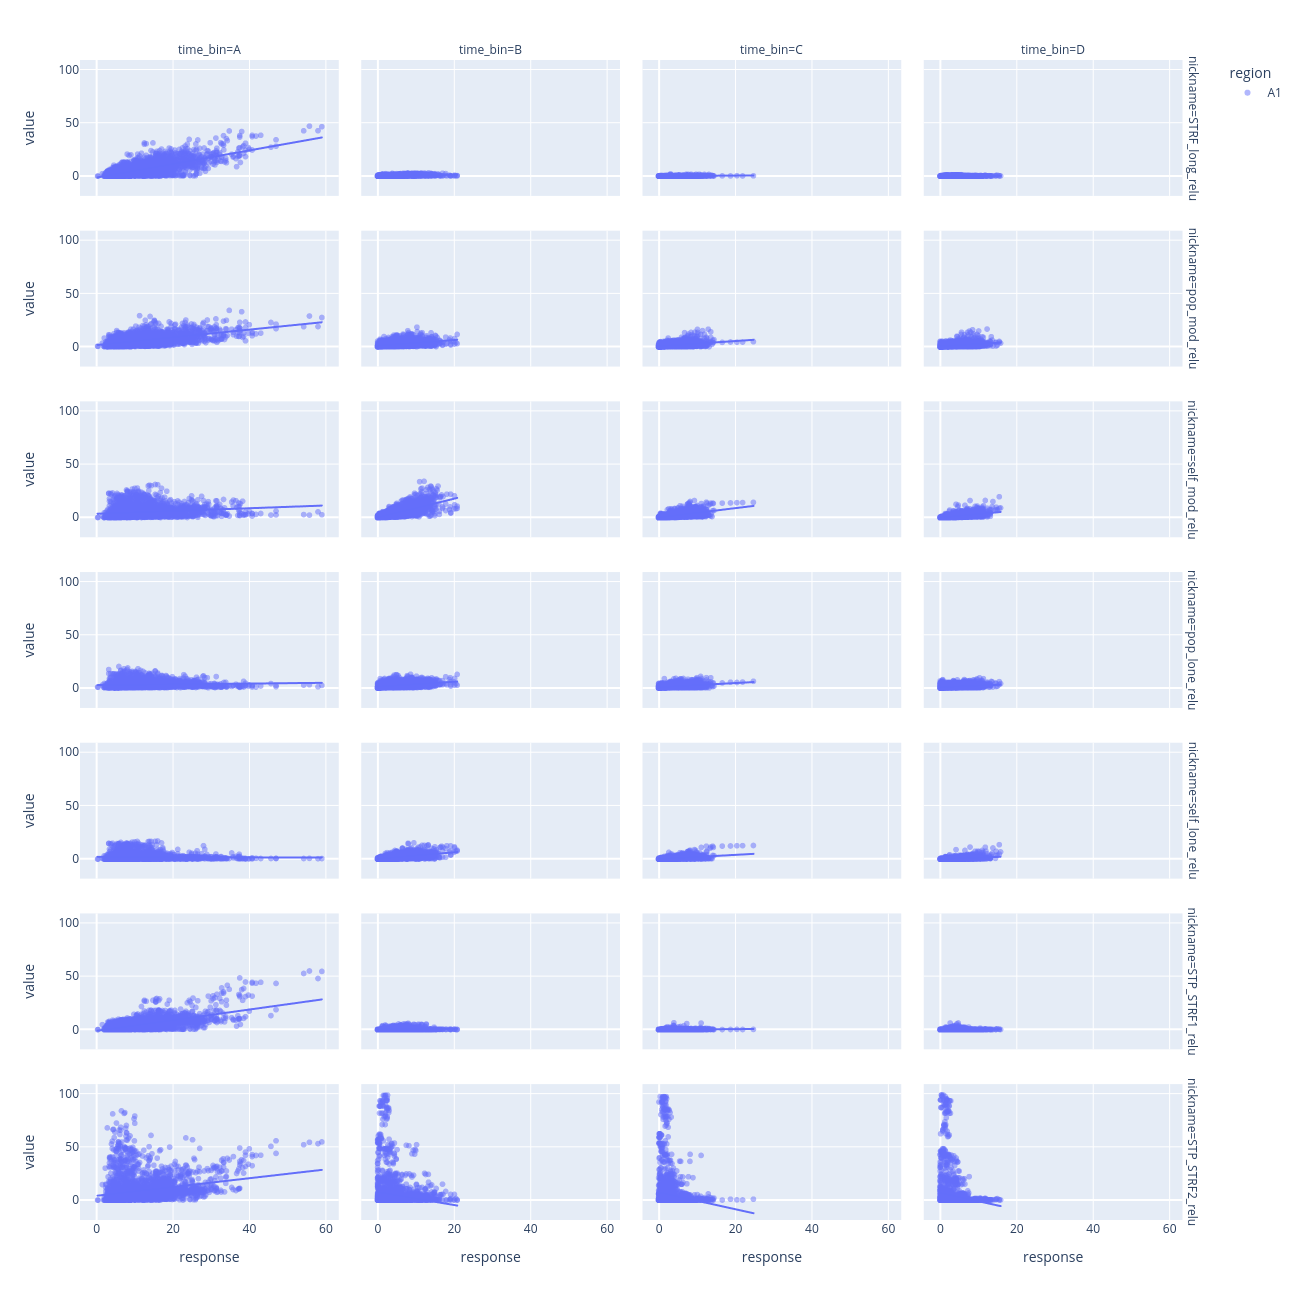

In [25]:
time_bins = ['A', 'B', 'C', 'D']

toplot = resp_wide.query(f"metric == 'integral' and time_bin in {time_bins}")

fig = px.scatter(toplot, x='response', y='value', facet_col='time_bin', facet_row='nickname', color='region',                 opacity=0.5, trendline='ols', log_x=False, log_y=False)
# fig.show()
img_bytes = fig.to_image(format="png", width=1300, height=1300)
Image(img_bytes)

# seems I will need to do some manual plotting to make things look good

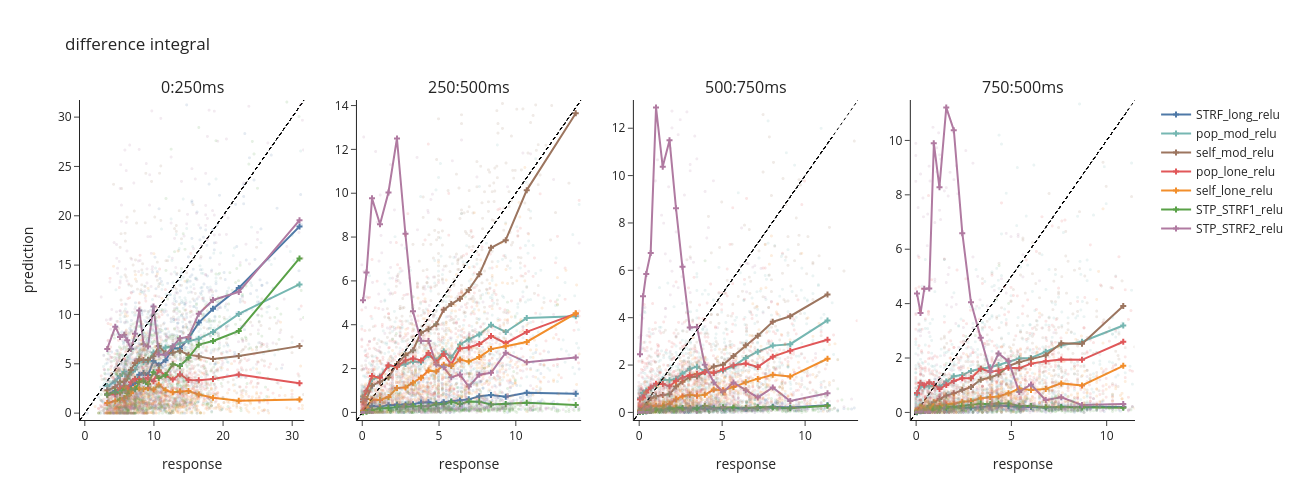

In [29]:
colormap = {'STRF_long_relu':Blue,
            'pop_lone_relu': Red,
            'pop_mod_relu':Teal,
            'self_mod_relu': Brown,
            'self_lone_relu': Orange,
            'STP_STRF1_relu': Green,
            'STP_STRF2_relu': Purple}
decimate = 20
time_bins = ['A', 'B', 'C', 'D']
fig = make_subplots(rows=1, cols=len(time_bins),
                    subplot_titles=['0:250ms', '250:500ms', '500:750ms', '750:500ms'])

for cc, tbin in enumerate(time_bins):
    for nn, nknm in enumerate(resp_wide.nickname.unique()):
        subplotdf = resp_wide.query(f"metric == 'integral' and time_bin == '{tbin}' and  nickname == '{nknm}'")

        if cc == 0:
            showlegend = True
        else:
            showlegend = False

        x = subplotdf.response.values.astype(float)
        y = subplotdf.value.values.astype(float)
        R2 = r2_score(x,y)

        # plots a fraction of the raw data
        rndsmp = np.random.random_sample(size=x.shape) < 0.2 # subsamples 20% of the data
        fig.add_trace(go.Scattergl(x=x[rndsmp], y=y[rndsmp], mode='markers',
                                   opacity=0.3,
                                   marker=dict(opacity=0.5,
                                               size=3,
                                               color=colormap[nknm],
                                               line_color='black'),
                                   showlegend=False,
                                   hoverinfo='skip'),
               row=1, col=cc+1)

        # decimated trend line
        srtidx = np.argsort(x)
        x = x[srtidx]
        y = y[srtidx]
        qntils = np.quantile(x,np.linspace(0,1,decimate+1), interpolation='higher')
        xm = np.empty((decimate))
        ym = np.empty((decimate))
        for rr in range(len(qntils)-1):
            if rr == 0:
                mask = (x<=qntils[rr+1])
            else:
                mask = (qntils[rr]<x) & (x<=qntils[rr+1])

            if mask.sum() == 0:
                xm[rr] = np.nan
                ym[rr] = np.nan
            else:
                xm[rr] = np.mean(x[mask])
                ym[rr] = np.mean(y[mask])

        R2m = r2_score(xm, ym)

        fig.add_trace(go.Scatter(x=xm, y=ym, mode='markers+lines',
                                 marker=dict(opacity=1,
                                             color=colormap[nknm],
                                             symbol='cross',
                                             size=5),
                                 line_width=2,
                                 hovertemplate=f'R2: {R2:.3f}\nR2m: {R2m:.3f}',
                                 name=f'{nknm}',
                                 showlegend=showlegend),
                      row=1, col=cc+1)


        # unity line
        plot_range = [np.nanmin(np.stack([xm,ym])),
                     np.nanmax(np.stack([xm,ym]))]
        plot_range = [0- (np.diff(plot_range)*0.025)[0], plot_range[1] + (np.diff(plot_range)*0.025)[0]]

        fig.add_trace(go.Scatter(x=plot_range, y=plot_range, mode='lines',
                                 line=dict(color='black',
                                           dash='dot',
                                           width=1),
                                 showlegend=False),
                      row=1, col=cc+1)

        fig.update_xaxes(range=plot_range, title_text='response', row=1, col=cc+1)

        if cc == 0:
            ylabel = 'prediction'
        else:
            ylabel = None
        fig.update_yaxes(range=plot_range, title_text=ylabel, scaleratio=1, row=1, col=cc+1)

fig.update_layout(showlegend=True, template='simple_white', title_text='difference integral')
# fig.show()
img_bytes = fig.to_image(format="png", width=1300)
Image(img_bytes)

## what is the right metric to take?
from the bunch of determination coefficients, it seems the models are in reality quite poor even if the regression
lines are actually pretty good.

In [30]:
grouped = resp_wide.query(f"metric == 'integral'").groupby(['time_bin', 'nickname'])

def f(group):
    x, y = group.response.values.astype(float), group.value.values.astype(float)
    R2 = r2_score(x, y)
    slope,_,rvalue,_,_ = sst.linregress(x,y)
    df = pd.Series({'R2':R2,
                    'slope':slope,
                    'r': rvalue,
                    'r2': rvalue**2})
    return df

grouped.apply(f)

R2     slope         r        r2
time_bin nickname                                               
A        STP_STRF1_relu  -0.626979  0.500935  0.630573  0.397623
         STP_STRF2_relu  -2.180645  0.413332  0.244140  0.059605
         STRF_long_relu  -0.190169  0.639802  0.703413  0.494790
         pop_lone_relu   -1.500320  0.035944  0.087330  0.007626
         pop_mod_relu    -0.290340  0.363350  0.560129  0.313745
         self_lone_relu  -2.057273 -0.011148 -0.028269  0.000799
         self_mod_relu   -1.096889  0.130427  0.180755  0.032672
B        STP_STRF1_relu  -1.582604  0.027438  0.161447  0.026065
         STP_STRF2_relu -13.987488 -0.612318 -0.171468  0.029401
         STRF_long_relu  -1.391840  0.058473  0.428978  0.184022
         pop_lone_relu   -0.289428  0.229045  0.421809  0.177923
         pop_mod_relu    -0.195951  0.264979  0.469432  0.220366
         self_lone_relu  -0.391524  0.304808  0.590757  0.348994
         self_mod_relu    0.324774  0.881123  0.738953  0.546052
C        STP_STRF1_relu  -1.359643  0.016554  0.178095  0.031718
         STP_STRF2_relu -20.779258 -0.794959 -0.181548  0.032960
         STRF_long_relu  -1.360653  0.019652  0.373129  0.139225
         pop_lone_relu   -0.334001  0.195450  0.443765  0.196927
         pop_mod_relu    -0.229967  0.242048  0.467887  0.218919
         self_lone_relu  -0.698155  0.196591  0.536653  0.287996
         self_mod_relu   -0.026768  0.439189  0.648128  0.420070
D        STP_STRF1_relu  -1.318739  0.012512  0.106988  0.011446
         STP_STRF2_relu -20.878820 -0.786652 -0.179061  0.032063
         STRF_long_relu  -1.329456  0.014921  0.246612  0.060818
         pop_lone_relu   -0.453089  0.148068  0.342247  0.117133
         pop_mod_relu    -0.317770  0.214565  0.411474  0.169311
         self_lone_relu  -0.884907  0.137411  0.476673  0.227218
         self_mod_relu   -0.267154  0.332148  0.628559  0.395086

## given the great performance of the autoregressor, check the weights
brown line in the models above, nickname: 'self_mod_relu'

In [ ]:
from src.models.param_tools import get_strf, get_population_weights
from src.utils.subsets import batch_map

# acumulate weight for ploted neurons, already filtered by real response quality
autoreg_df = list()
bads = list()
for cellid in resp_wide.id.unique().tolist():
    try:
        w = get_population_weights(cellid, batch_map[cellid], modelnames['self_mod_relu'])
    except:
        bads.append(f'{cellid}/self_mod_relu')

    d = {'id': cellid,
         'weight': w[0]}
    autoreg_df.append(d)
autoreg_df = pd.DataFrame(autoreg_df)


In [14]:
print(f'parametes not found for: {bads}')

parametes not found for: ['TNC016a-33-2/self_mod_relu', 'TNC016a-30-2/self_mod_relu', 'TNC016a-16-2/self_mod_relu', 'TNC016a-43-6/self_mod_relu', 'TNC009a-31-1/self_mod_relu', 'TNC009a-42-1/self_mod_relu', 'TNC009a-52-1/self_mod_relu', 'TNC009a-13-1/self_mod_relu', 'TNC014a-22-2/self_mod_relu', 'TNC014a-39-2/self_mod_relu', 'TNC014a-16-3/self_mod_relu', 'TNC014a-40-4/self_mod_relu', 'TNC014a-43-2/self_mod_relu', 'TNC014a-57-1/self_mod_relu', 'TNC015a-23-2/self_mod_relu', 'TNC015a-39-4/self_mod_relu']


In [13]:
fig = px.histogram(autoreg_df,x='weight')
fig.show()

In [15]:
lone_df = list()
bads = list()
for cellid in resp_wide.id.unique().tolist():
    try:
        w = get_population_weights(cellid, batch_map[cellid], modelnames['self_lone_relu'])
    except:
        bads.append(f'{cellid}/self_mod_relu')

    d = {'id': cellid,
         'weight': w[0]}
    lone_df.append(d)
lone_df = pd.DataFrame(autoreg_df)

[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/326/TNC017a-33-2/ozgf.fs100.ch18-ld-norm.l1-dline.15.15.1.i.resp.o.stim-epcpn.seq-avgreps.wc.Nx1-...-914891442625854056 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/326/TNC017a-34-4/ozgf.fs100.ch18-ld-norm.l1-dline.15.15.1.i.resp.o.stim-epcpn.seq-avgreps.wc.Nx1-...2017030191475151269 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/326/TNC017a-13-3/ozgf.fs100.ch18-ld-norm.l1-dline.15.15.1.i.resp.o.stim-epcpn.seq-avgreps.wc.Nx1-...4850826981048330272 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/326/TNC017a-14-2/ozgf.fs100.ch18-ld-norm.l1-dline.15.15.1.i.resp.o.stim-epcpn.seq-avgreps.wc.Nx1-...2533702147145834128 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/326/TNC017a-25-6/ozgf.fs100.ch18-ld-norm.l1-dline.15.15.1.i.resp.o.stim-epcpn.seq-avgreps.wc.Nx1-...42243795760416

In [16]:
fig = px.histogram(lone_df,x='weight')
fig.show()